# Preprocessing Tutorial

This tutorial is designed to show you how Dynamo preprocess the regular scRNA-seq or time-resolved metabolic labeling enabled scRNA-seq data. In this new release of `dynamo 1.3.0`, we introduce the `Preprocessor` class (many parts of it has been implemented previously and but extensively updated and refined in this release), which allows you to convenietntly explore different preprocessing recipes with configurable parameters inside the class. The `Preprocessor` currently includes several existing recipes such as `monocle`, `pearson residual`, `seurat`, and `sctransform`. Furthermore, you can easily replace each preprocessing step with your own method of preprocessing. For example, the Preprocessor's monocle pipeline contains steps such as `filter_cells_by_outliers`, `filter_genes_by_outliers`, `normalize_by_cells`, and `select_genes`. You can replace the default preprocessing steps with your own method and modify default monocle parameters passed into these functions by reconfiguring the attributes of the Preprocessor class.

## The recipes in dynamo

To make your life easy, currently dynamo supports 4 major receipe for preprocessing. Please find at the end of this tutorial how you can customize your preprocessing method. 

* `Monocle`: Monocle recipe uses similar but generalized strategy from [Monocle 3](https://cole-trapnell-lab.github.io/monocle3/) to normalize all datasets in different layers (the spliced and unspliced or new, i.e. metabolic labelled, and total mRNAs or others), followed by feature selection, log1p transformation of the data and principal component analysis (PCA) dimension reduction. For more details, please refer to the [paper](https://cole-trapnell-lab.github.io/monocle3/papers/) and [code](https://github.com/Ukyeon/dynamo-release/blob/e7dd31408dabe5ce44e79a489badb106626a7109/dynamo/preprocessing/Preprocessor.py#L500).
* `Pearson Residuals`: Pearson Residuals recipe implements a preprocessing pipeline proposed in the study by Lause, Berens, and Kobak (2021) that uses Pearson Residuals for the normalization of single-cell RNA-seq UMI data. This method performs several steps including standardization, filtering of cells and genes by outliers, select_genes_by_pearson_residuals, appending or excluding gene lists, normalize_layers_pearson_residuals, regression, and PCA. This pipeline aims to preprocess the data using the Pearson residuals method to prepare it for downstream analysis. For more details, please refer to the [paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02451-7) and [code](https://github.com/Ukyeon/dynamo-release/blob/e7dd31408dabe5ce44e79a489badb106626a7109/dynamo/preprocessing/Preprocessor.py#L681).
* `Seurat`: Seurat recipe implements a preprocessing pipeline based on the Seurat package's approach to single-cell data integration and analysis. This recipe performs various steps including standardization, filtering of cells and genes by outliers, calculation of size factors, normalization by cells, gene selection, appending or excluding gene lists, normalization method selection, regression, and PCA. This pipeline follows the Seurat methodology for preprocessing single-cell data, as described in the [publications](https://www.biorxiv.org/content/10.1101/460147v1) by Stuart and Butler et al. (Cell, 2019) and Butler et al. (Nat Biotechnol). The goal is to prepare the data for downstream analysis and integration using Seurat's methods. For more details, please refer to the [code](https://github.com/Ukyeon/dynamo-release/blob/e7dd31408dabe5ce44e79a489badb106626a7109/dynamo/preprocessing/Preprocessor.py#L558) and [documentation](https://satijalab.org/seurat/).
* `Sctransform`: Sctransform recipe implements a preprocessing pipeline based on the sctransform method developed by Hao and Hao et al. This performs several steps including standardization, filtering of cells and genes by outliers, gene selection, appending or excluding gene lists, performing the sctransform method, regression, and PCA. The sctransform method is a model of single cell UMI expression data using regularized negative binomial regression and an integrated analysis approach for multimodal single-cell data. This pipeline aims to preprocess the data using the sctransform method to account for downstream analysis. For more details, please refer to the [paper](https://www.sciencedirect.com/science/article/pii/S0092867421005833), [code](https://github.com/Ukyeon/dynamo-release/blob/e7dd31408dabe5ce44e79a489badb106626a7109/dynamo/preprocessing/Preprocessor.py#L619), and [R code](https://github.com/satijalab/sctransform).

Note: In older versions, dynamo offered several recipes, among which `recipe_monocle` is a basic function as a building block of other recipes. You can still use these functions to preprocess data.

Preprocessor provides users with `config_monocle_recipe` and other `config_*_recipes` methods to help you reproduce different preprocessor results and integrate with your newly developed preprocessing algorithms.

Without further ado, let's begin by importing packages.

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed") 

In [2]:
import dynamo as dyn
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

If you would like to enable debug log messages to check the preprocessing procedure, simply uncomment the code snippet below

In [3]:
# dyn.dynamo_logger.main_set_level("DEBUG")

## Glossary of keys generated during preprocessing


#### you do need to update all list to series... 

- `adata.obs.pass_basic_filter`: a *series* of boolean variables indicating whether cells pass certain basic filters. In monocle recipe, the basic filtering is based on thresholding of expression values.
- `adata.var.pass_basic_filter`: a *series* of boolean variables indicating whether genes pass certain basic filters. In monocle recipe, the basic filtering is based on thresholding of expression values.
- `adata.var.use_for_pca`: a *series* of boolean variables points to feature genes selected for PCA dimension reduction and following downstream RNA velocity and vector field analysis. In many recipes, this key is equivalent to highly variable genes.
- `adata.var.highly_variable_scores`: a *series* of float number scores indicating how variable each gene is, typically generated during gene feature selection (`preprocessor.select_genes`). Note only part of recipes do not have this highly variable scores. E.g. `seuratV3` recipe implemented in dynamo does not have highly variable scores due to its thresholding nature.
- `adata.layers['X_spliced']`: spliced expression matrix after normalization used in downstream computation.
- `data.layers['X_unspliced']`: unspliced expression matrix after normalization used in downstream computation.
- `adata.obsm['X_pca']`: normalized X after PCA transformation.
- `adata.X`: normalized X (e.g. size factor normalized and log1p transformed)

## Using predefined (default) recipe configurations in preprocessor

Firstly, you can just start with the inclusion of a preprocessor, so that your life can become much easier. 
With just three lines of code, the preprocessor can handle the entire process of data filtering, manipulation, calculation, and conversion. You no longer have to worry about the headaches associated with these tasks.

In [4]:
from dynamo.preprocessing import Preprocessor

### Applying Monocle Recipe

In [5]:
# download the data 
adata = dyn.sample_data.zebrafish()
celltype_key = "Cell_type"

|-----> Downloading data to ./data/zebrafish.h5ad


In [6]:
adata

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    layers: 'spliced', 'unspliced'

In [7]:
preprocessor = Preprocessor()
preprocessor.preprocess_adata(adata, recipe="monocle")

# Alternative
# preprocessor.config_monocle_recipe(adata)
# preprocessor.preprocess_adata_monocle(adata)

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 14 outlier cells
|-----------> filtered out 12746 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-monocle] completed [3.5468s]


In [8]:
adata

AnnData object with n_obs × n_vars = 4167 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'score', 'log_m', 'frac', 'use_for_pca', 'ntr'
    uns: 'pp', 'velocyto_SVR', 'feature_selection', 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_pca'
    layers: 'spliced', 'unspliced', 'X_spliced', 'X_unspliced'

|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [27.4297s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


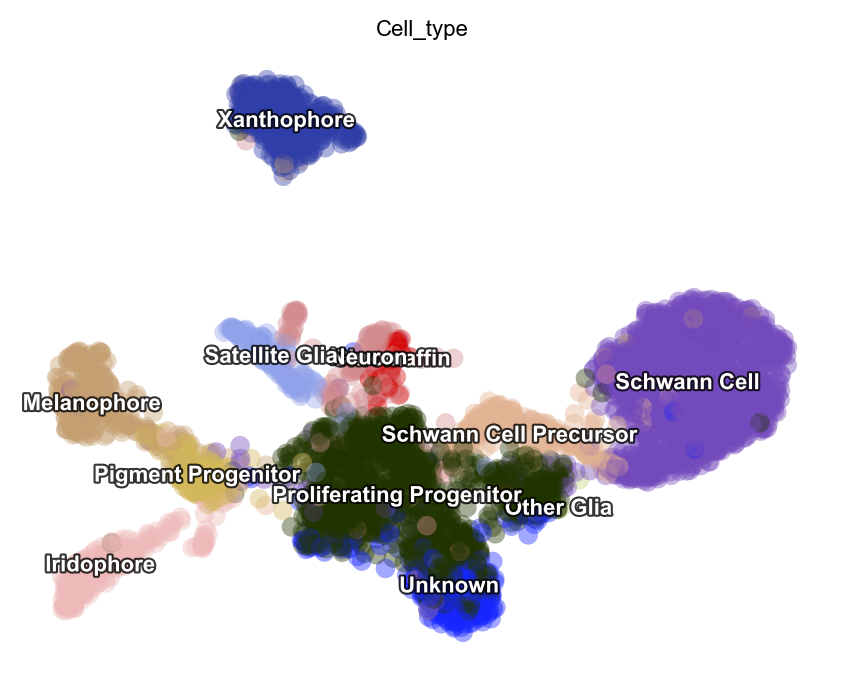

In [9]:
dyn.tl.reduceDimension(adata, basis="pca")
# pointsize can be used to set the size of data points (cells) while alpha set the transparency value of the data points 
dyn.pl.umap(adata, color=celltype_key, pointsize=0.2, alpha=0.4) 

### Applying Pearson Residuals Recipe

Please note that pearson residual or sctransform transformation should only be performed for adata.X and not applied to different layers. This is because RNA velocity do have physical meanings, and otherwise spliced/unspliced data will reseult in negative values after transformation. 

In [10]:
adata = dyn.sample_data.zebrafish()
preprocessor = Preprocessor()

preprocessor.preprocess_adata(adata, recipe="pearson_residuals")

# Alternative
# preprocessor.config_pearson_residuals_recipe(adata)
# preprocessor.preprocess_adata_pearson_residuals(adata)

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> gene selection on layer: X
|-----> extracting highly variable genes
|-----------> filtered out 350 outlier genes
|-----> applying Pearson residuals to layer <X>
|-----> replacing layer <X> with pearson residual normalized data.
|-----> [pearson residual normalization for X] completed [1.1042s]
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-pearson residual] completed [4.8708s]


|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [16.7289s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


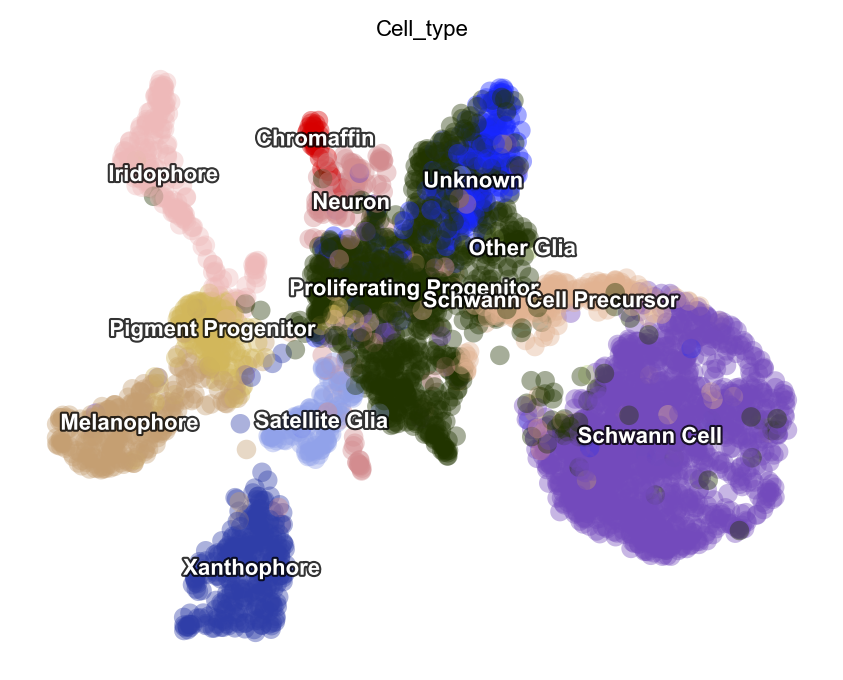

In [11]:
dyn.tl.reduceDimension(adata)
dyn.pl.umap(adata, color=celltype_key, pointsize=0.2, alpha=0.4)

### Applying Sctransform Recipe

Sctransform transformation is only applied to adata.X and not applied to different layers, as stated above. 

In [12]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='Сould not load pytorch')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

adata = dyn.sample_data.zebrafish()
preprocessor = Preprocessor()

preprocessor.preprocess_adata(adata, recipe="sctransform")

# Alternative
# preprocessor.config_sctransform_recipe(adata)
# preprocessor.preprocess_adata_sctransform(adata)

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> Running Sctransform recipe preprocessing...
|-----------> filtered out 14 outlier cells
|-----------> filtered out 12410 outlier genes
|-----? Sctransform recipe will subset the data first with default gene selection function for efficiency. If you want to disable this, please perform sctransform without recipe.
|-----> sctransform adata on layer: X
|-----------> set sctransform results to adata.X
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-sctransform] completed [16.6057s]


|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [16.2677s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


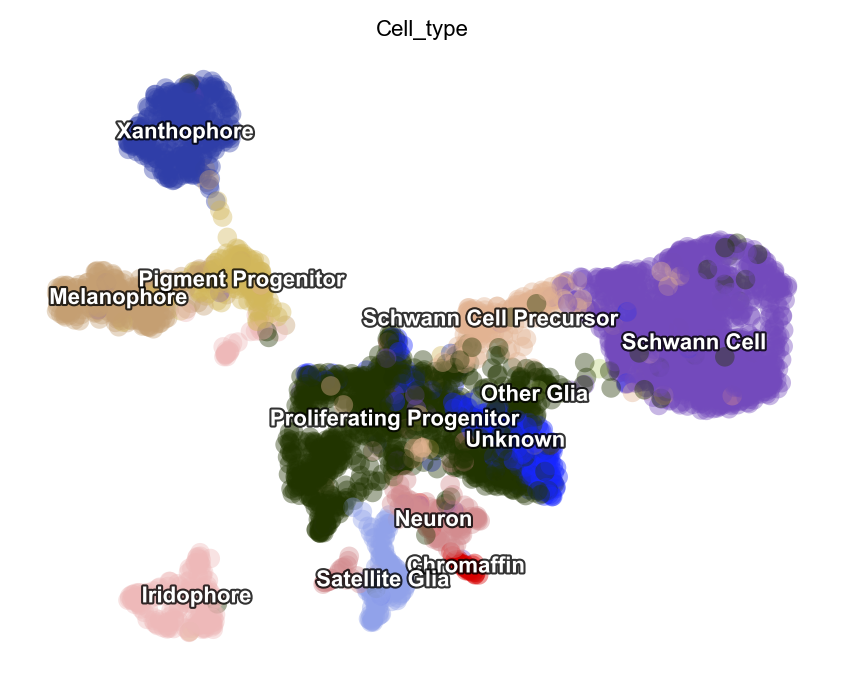

In [13]:
dyn.tl.reduceDimension(adata)
dyn.pl.umap(adata, color=celltype_key, pointsize=0.2, alpha=0.4)

### Applying Seurat Recipe

In [14]:
adata = dyn.sample_data.zebrafish()
preprocessor = Preprocessor()

# Alternative
# preprocessor.config_seurat_recipe(adata)
# preprocessor.preprocess_adata_seurat(adata)

preprocessor.preprocess_adata(adata, recipe="seurat")

|-----> Downloading data to ./data/zebrafish.h5ad
|-----> Running Seurat recipe preprocessing...
|-----------> filtered out 14 outlier cells
|-----------> filtered out 11388 outlier genes
|-----> select genes on var key: pass_basic_filter
|-----------> choose 2000 top genes
|-----> number of selected highly variable genes: 2000
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-seurat] completed [1.4041s]


|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [16.0549s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


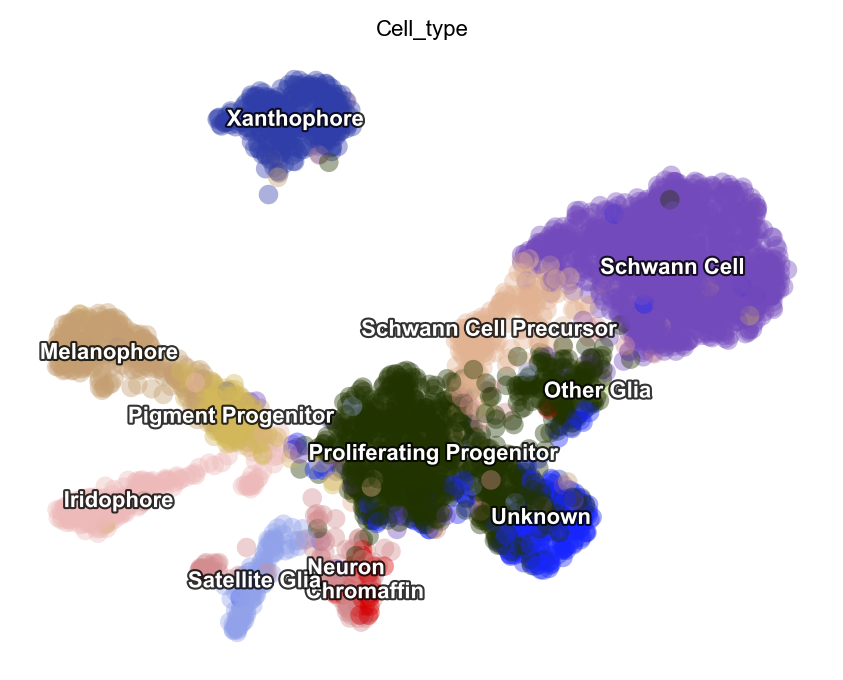

In [15]:
dyn.tl.reduceDimension(adata)
dyn.pl.umap(adata, color=celltype_key, pointsize=0.2, alpha=0.4)

## Customize function parameters configured in Preprocessor

In this example, we will use the monocle recipe to demonstrate how we can configure Preprocessor cluster to select genes based on your needs. Note that we can set the recipe to be `dynamo_monocle`, `seurat`, or others to apply different criteria for selecting genes. We can also set the `select_genes_kwargs` parameter in the preprocessor to pass additional desired parameters. By default, the recipe is set to `dynamo_monocle`. We can change it to `seurat` and add other constraint parameters if needed.

In [16]:
adata = dyn.sample_data.zebrafish()
preprocessor = Preprocessor()
preprocessor.config_monocle_recipe(adata)

|-----> Downloading data to ./data/zebrafish.h5ad


`preprocessor.select_genes_kwargs` contains arguments that will be passed to `select_genes` step.

In [17]:
preprocessor.select_genes_kwargs

{'n_top_genes': 2000, 'SVRs_kwargs': {'relative_expr': False}}

To set the preprocessing steps and their corresponding function parameters for the monocle recipe, we can call `preprocessor.config_monocle_recipe()`. By default, the constructor parameters of the Preprocessor for preprocessing are set to the monocle recipe used in report the Dynamo cell paper [dynamo](https://www.cell.com/cell/pdf/S0092-8674(21)01577-4.pdf).

If you would like to customize the dataset to better fit your preferences, you can adjust the parameters before running the recipe. Here is an example.

To begin, you can create a plot of the basic statistics (nGenes, nCounts, and pMito) for each category of adata.
- nGenes: the number of genes
- nCounts: the number of cells
- pMito: the percentage of mitochondria genes.

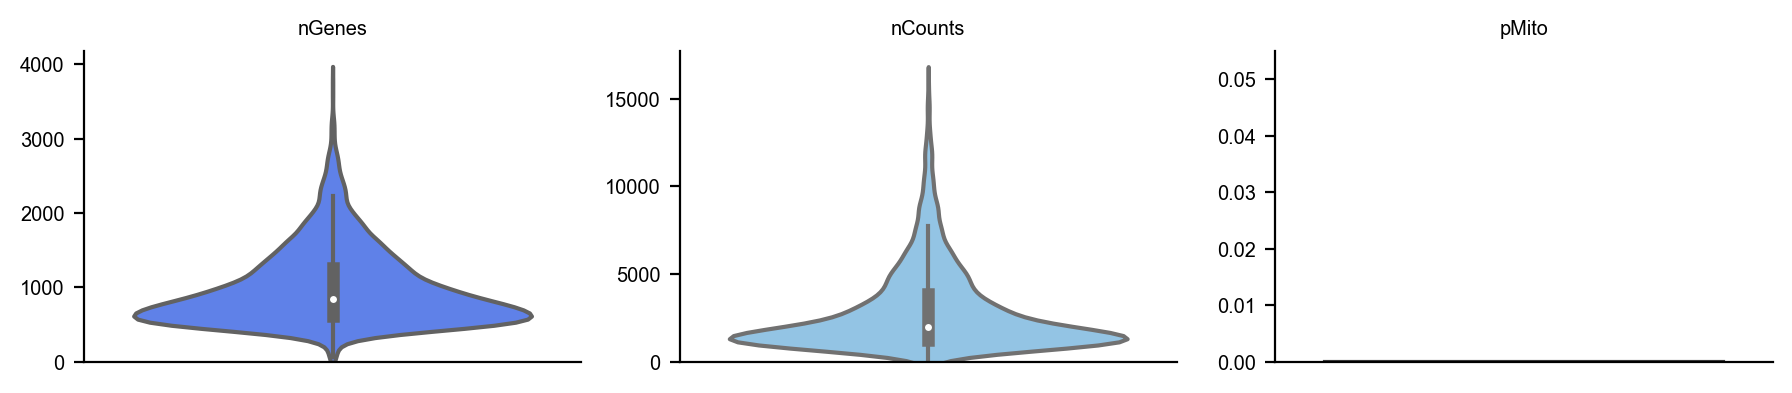

In [18]:
dyn.pl.basic_stats(adata, figsize=(3, 2))

You can visualize the rank of the fraction of UMI to the total UMI per cell for the top 20 genes

|-----------? use_for_pca not in adata.var, ignoring the gene annotation key when plotting


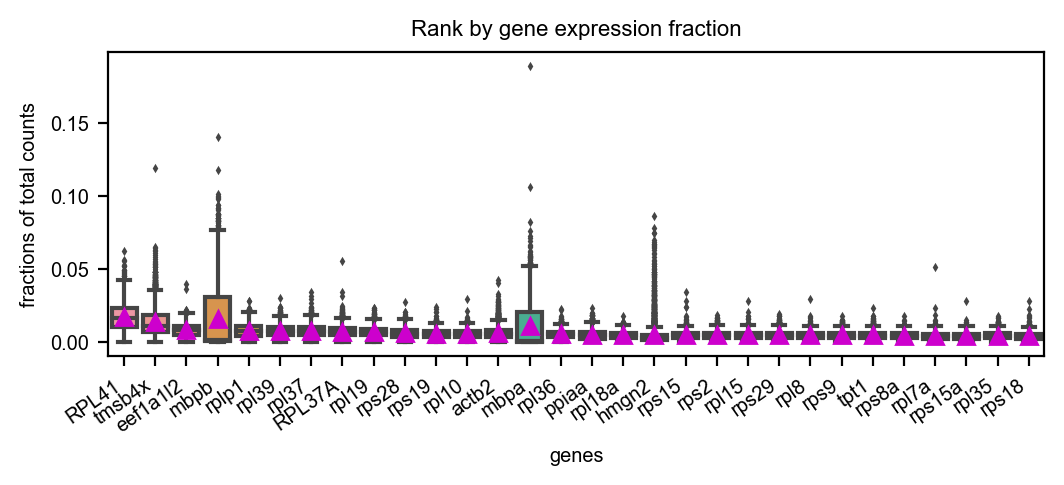

<AxesSubplot:title={'center':'Rank by gene expression fraction'}, xlabel='genes', ylabel='fractions of total counts'>

In [19]:
dyn.pl.highest_frac_genes(adata, figsize=(6, 2))

You can get rid of any cells that have mitochondrial gene expression percentage greater than pMito or total counts greater than nCounts. You can adjust the threshold values as per your requirements.

Note that in our particular case, our data doesn't have mitochondria counts.

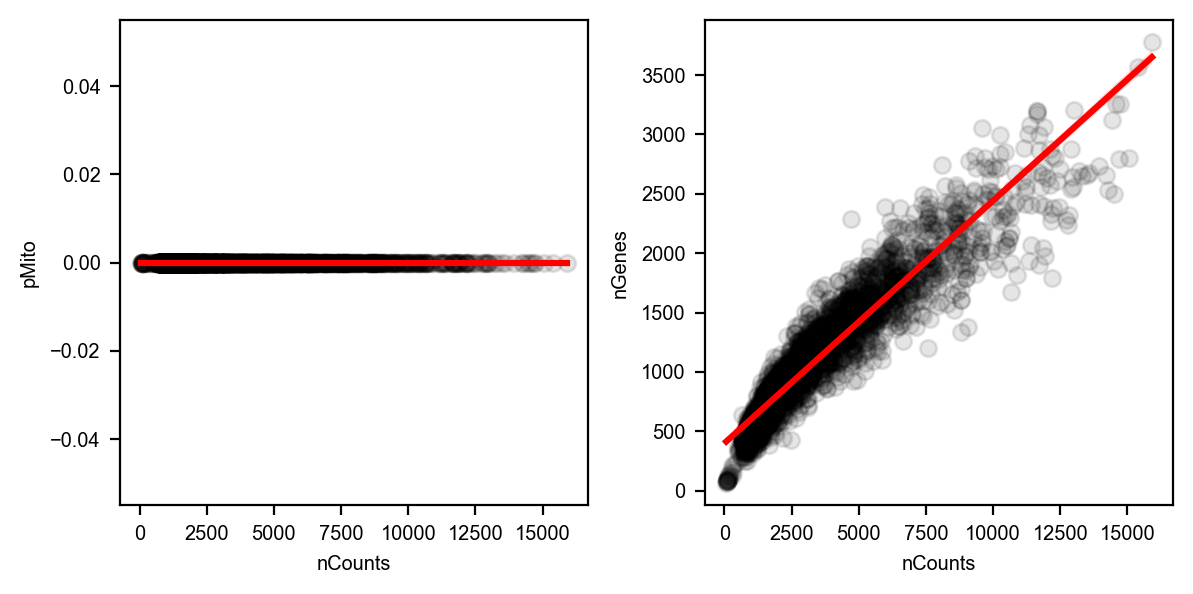

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the first figure
df = adata.obs.loc[:, ["nCounts", "pMito", "nGenes"]]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))  # Adjust the figsize as desired

sns.regplot(data=df, 
            x="nCounts", 
            y="pMito", 
            ax=ax1,
            scatter_kws={"color": "black",  "alpha": 0.1}, 
            line_kws={"color": "red"})
ax1.set_xlabel("nCounts")
ax1.set_ylabel("pMito")

# Create the second figure
sns.regplot(data=df, 
            x="nCounts", 
            y="nGenes", 
            ax=ax2, 
            scatter_kws={"color": "black",  "alpha": 0.1}, 
            line_kws={"color": "red"})
ax2.set_xlabel("nCounts")
ax2.set_ylabel("nGenes")

# Display the figures side by side
plt.tight_layout()  # Optional: Adjusts spacing between subplots
plt.show()


And modify some values of parameters based on the information above.

In [21]:
preprocessor.filter_cells_by_outliers_kwargs = {
    "filter_bool": None,
    "layer": "all",
    "min_expr_genes_s": 300,
    "min_expr_genes_u": 100,
    "min_expr_genes_p": 50,
    "max_expr_genes_s": np.inf,
    "max_expr_genes_u": np.inf,
    "max_expr_genes_p": np.inf,
    "shared_count": None,
}


In [22]:
preprocessor.filter_genes_by_outliers_kwargs = {
    "filter_bool": None,
    "layer": "all",
    "min_cell_s": 3,
    "min_cell_u": 2,
    "min_cell_p": 1,
    "min_avg_exp_s": 0,
    "min_avg_exp_u": 0,
    "min_avg_exp_p": 0,
    "max_avg_exp": np.inf,
    "min_count_s": 5,
    "min_count_u": 0,
    "min_count_p": 0,
    "shared_count": 40,
}

In [23]:
preprocessor.select_genes_kwargs = {
    "n_top_genes": 2500,
    "sort_by": "cv_dispersion",
    "keep_filtered": True,
    "SVRs_kwargs": {
        "relative_expr": True,
        "total_szfactor": "total_Size_Factor",
        "min_expr_cells": 0,
        "min_expr_avg": 0,
        "max_expr_avg": np.inf,
        "winsorize": False,
        "winsor_perc": (1, 99.5),
        "sort_inverse": False,
        "svr_gamma": None,
    },
}

Let`s run the monocle recipe again.

In [24]:
preprocessor.preprocess_adata_monocle(adata)

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 125 outlier cells
|-----------> filtered out 13035 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-monocle] completed [2.9955s]


|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [25.0124s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


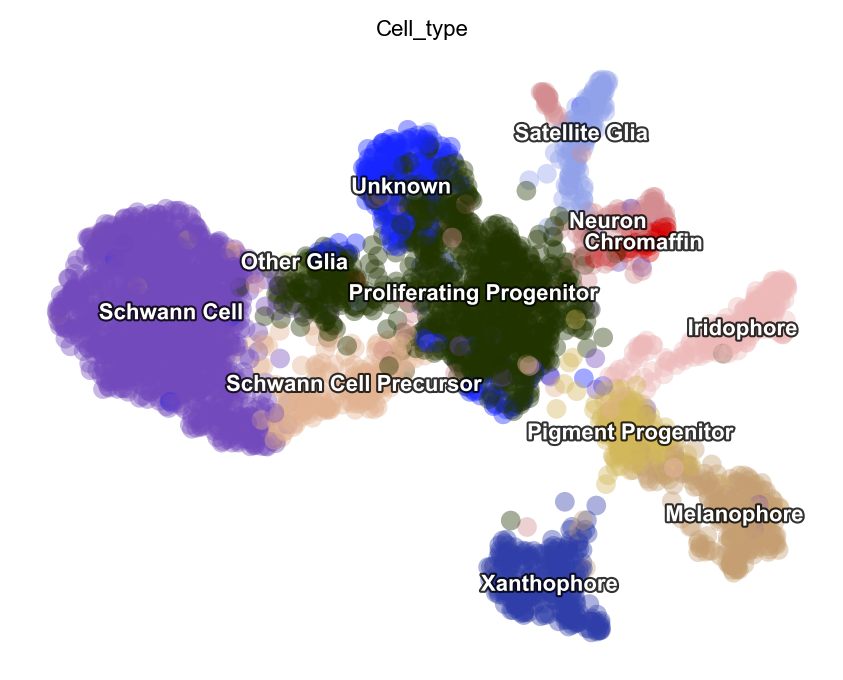

In [25]:
dyn.tl.reduceDimension(adata, basis="pca")
dyn.pl.umap(adata, color=celltype_key, pointsize=0.2, alpha=0.4)

Let`s run the seurat recipe in this time.

In [26]:
adata = dyn.sample_data.zebrafish()
preprocessor = Preprocessor()
preprocessor.config_seurat_recipe(adata)

|-----> Downloading data to ./data/zebrafish.h5ad


In [27]:
preprocessor.select_genes_kwargs

{'algorithm': 'seurat_dispersion', 'n_top_genes': 2000}

In [28]:
preprocessor.select_genes_kwargs = dict(
    n_top_genes=2500,
    algorithm="seurat_dispersion", # or "fano_dispersion"
    seurat_min_disp=None,
    seurat_max_disp=None,
    seurat_min_mean=0.4,
    seurat_max_mean=0.6,
)
preprocessor.select_genes_kwargs

{'n_top_genes': 2500,
 'algorithm': 'seurat_dispersion',
 'seurat_min_disp': None,
 'seurat_max_disp': None,
 'seurat_min_mean': 0.4,
 'seurat_max_mean': 0.6}

|-----> Running Seurat recipe preprocessing...
|-----------> filtered out 14 outlier cells
|-----------> filtered out 11388 outlier genes
|-----> select genes on var key: pass_basic_filter
|-----------> choose 2500 top genes
|-----> number of selected highly variable genes: 2500
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-seurat] completed [1.4892s]
|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [15.9357s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


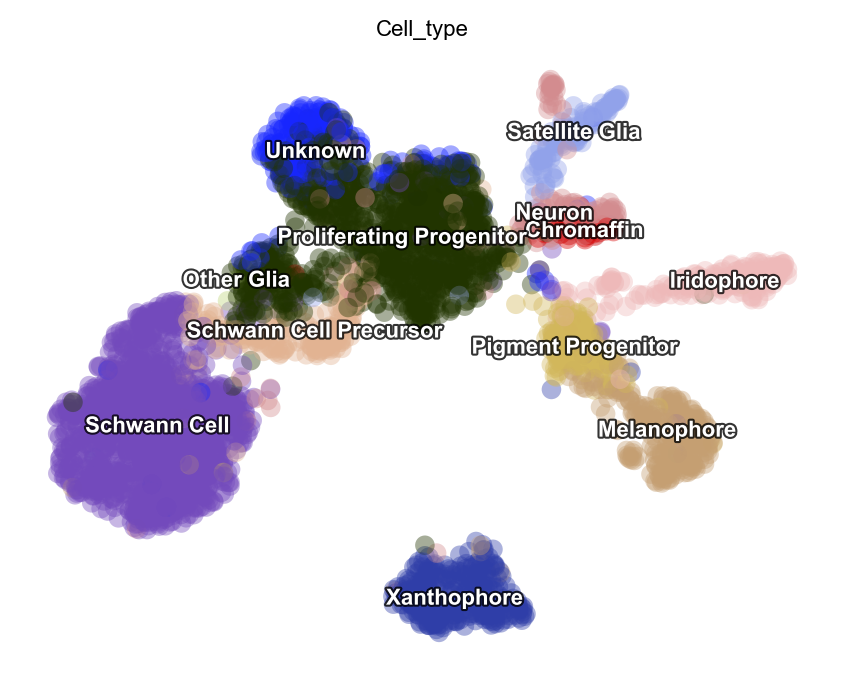

In [29]:
preprocessor.preprocess_adata_seurat(adata)
dyn.tl.reduceDimension(adata, basis="pca")
dyn.pl.umap(adata, color=celltype_key, pointsize=0.2, alpha=0.4)

## Customize and run each functions directly.

We understand that some of you may prefer to use the each function by calling your own customized parameters. To cater to these needs, we have prepared the following guidances help you utilizing the conventional steps with our new preprocessor class. This way, you can still take advantage of the benefits of the preprocessor while also incorporating your own specific requirements.

In [30]:
pp = Preprocessor()
adata = dyn.sample_data.zebrafish()
pp.standardize_adata(adata, 'time', None)

|-----> Downloading data to ./data/zebrafish.h5ad


In [31]:
adata

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito'
    var: 'nCells', 'nCounts'
    uns: 'pp'
    layers: 'spliced', 'unspliced'

In [32]:
pp.filter_cells_by_outliers(adata, max_expr_genes_s=2000)

|-----------> filtered out 244 outlier cells


AnnData object with n_obs × n_vars = 3937 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter'
    var: 'nCells', 'nCounts'
    uns: 'pp'
    layers: 'spliced', 'unspliced'

In [33]:
pp.filter_genes_by_outliers(adata, max_avg_exp=2000, shared_count=40)

|-----------> filtered out 13890 outlier genes


tmsb4x         True
rpl8           True
ppiaa          True
rpl10a         True
rps4x          True
              ...  
cdc42ep1a     False
camk1da       False
zdhhc22       False
zgc:153681    False
mmp16b        False
Name: pass_basic_filter, Length: 16940, dtype: bool

In [34]:
adata.var['pass_basic_filter'].sum()

3050

In [35]:
pp.normalize_by_cells(adata)

AnnData object with n_obs × n_vars = 3937 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'initial_cell_size'
    var: 'nCells', 'nCounts', 'pass_basic_filter'
    uns: 'pp'
    layers: 'spliced', 'unspliced', 'X_spliced', 'X_unspliced'

In [36]:
pp.select_genes(adata, sort_by="fano_dispersion") # "cv_dispersion" or "gini"

In [37]:
pp.norm_method(adata) # log1p

AnnData object with n_obs × n_vars = 3937 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'initial_cell_size'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'score', 'log_m', 'frac', 'use_for_pca'
    uns: 'pp', 'velocyto_SVR', 'feature_selection'
    layers: 'spliced', 'unspliced', 'X_spliced', 'X_unspliced'

In [38]:
pp.regress_out(adata, obs_keys=['nCounts', 'pMito'])

|-----> [regress out] completed [28.5796s]


In [39]:
pp.pca(adata)

|-----> <insert> X_pca to obsm in AnnData Object.


AnnData object with n_obs × n_vars = 3937 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'initial_cell_size'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'score', 'log_m', 'frac', 'use_for_pca'
    uns: 'pp', 'velocyto_SVR', 'feature_selection', 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_pca'
    layers: 'spliced', 'unspliced', 'X_spliced', 'X_unspliced'

|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [21.4056s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


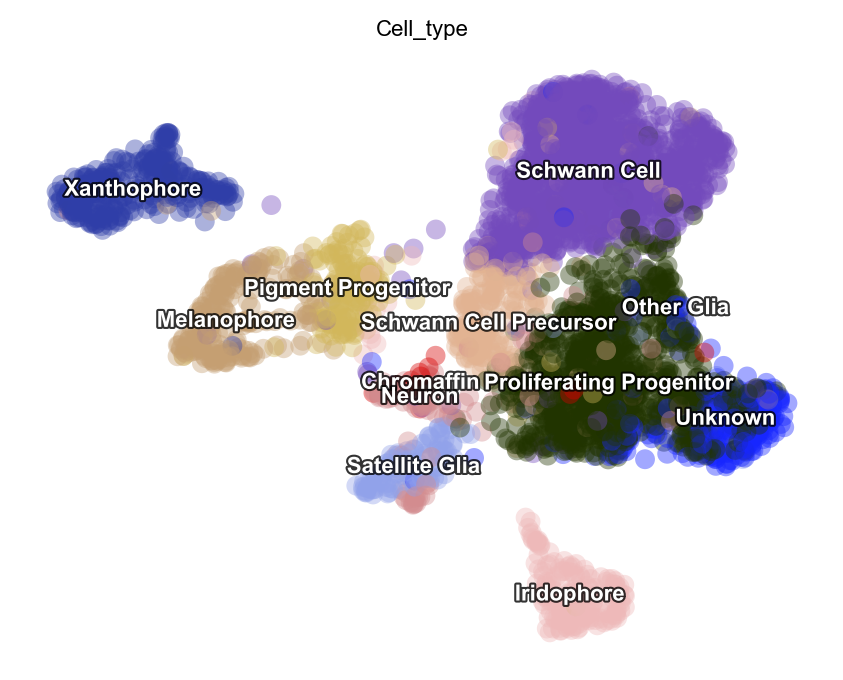

In [40]:
dyn.tl.reduceDimension(adata, basis="pca")
dyn.pl.umap(adata, color="Cell_type", pointsize=0.2, alpha=0.4)